# Xinqiao Tong Solution

First we use a **scrawler** to download forecast data for 2024-04-01 to 2024-04-22. 

The forecasts were made on 6 AM each day from 2024-03-31 to 2024-04-21.

In [26]:
###############################################    CRAWLER    ###############################################
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
from selenium.webdriver.chrome.options import Options
chrome_options = webdriver.ChromeOptions()
chrome_options.add_experimental_option("prefs", {
    "download.default_directory": "D:\desktop",
    "download.prompt_for_download": False,
    "download.directory_upgrade": True,
    "safebrowsing_for_trusted_sources_enabled": False,
    "safebrowsing.enabled": False
})


def my_crawler(date):
    # Locate the date input field using an absolute XPath
    date_input_box = driver.find_element(By.XPATH, "/html/body/app-root/main/dm-feed/div/div[2]/feed-grid/div/div[1]/datepicker-list/div/div[2]/div/input")
    # Clear any existing content in the input field
    date_input_box.clear()
    # Send the specified date to the input field
    date_input_box.send_keys(date)
    # Locate the second date input field, generally used for setting an end date or another reference time
    date_input_box2 = driver.find_element(By.XPATH, "/html/body/app-root/main/dm-feed/div/div[2]/feed-grid/div/div[1]/datepicker-list/div/div[3]/div/input")
    date_input_box2.clear()
    date_input_box2.send_keys(date)

    # Locate the time input field using an absolute XPath
    time_input_box = driver.find_element(By.XPATH, "/html/body/app-root/main/dm-feed/div/div[2]/feed-grid/div/div[1]/datepicker-list/div/div[2]/timepicker/div/input")
    time_input_box.clear()
    # Input a fixed time value
    time_input_box.send_keys("0600")
    # Adjust cursor position to correct the time format
    time_input_box.send_keys(Keys.ARROW_LEFT)
    time_input_box.send_keys(Keys.ARROW_LEFT)
    # Insert a colon to correct the time format
    time_input_box.send_keys(':')

    # Perform similar actions on the second time input field
    time_input_box2 = driver.find_element(By.XPATH, "/html/body/app-root/main/dm-feed/div/div[2]/feed-grid/div/div[1]/datepicker-list/div/div[3]/timepicker/div/input")
    time_input_box2.clear()
    time_input_box2.send_keys("0600")
    time_input_box2.send_keys(Keys.ARROW_LEFT)
    time_input_box2.send_keys(Keys.ARROW_LEFT)
    time_input_box2.send_keys(':')

    # Wait for 5 seconds, possibly to allow for page response or to ensure completion of operations
    time.sleep(5)
    # Locate and wait until the button is clickable, the button is used for submitting date and time data
    button_xpath = "/html/body/app-root/main/dm-feed/div/div[2]/feed-grid/div/div[1]/datepicker-list/div/div[4]/button[1]"
    wait = WebDriverWait(driver, 15)
    button = wait.until(EC.element_to_be_clickable((By.XPATH, button_xpath)))
    button.click()

    # Wait again for 5 seconds, possibly for data processing or page update
    time.sleep(5)
    # Execute JavaScript to click the export to CSV button
    driver.execute_script("document.querySelector('.ui-icon-export-csv').click();")
    # Finally, wait another 5 seconds to ensure the file is downloaded completely
    time.sleep(5)

In [ ]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
driver.get("https://dataminer2.pjm.com/feed/hourly_wind_power_forecast")
time.sleep(5)

from datetime import datetime, timedelta

start_date = datetime(2024, 3, 31)
end_date = datetime(2024, 4, 21)

# dates to download
date_strings = [(start_date + timedelta(days=x)).strftime('%m/%d/%Y') for x in range((end_date - start_date).days + 1)]

for date in date_strings:
    my_crawler(date)

driver.quit()

#### Crawler ends its job here. 

In [1]:
import torch
import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
import matplotlib.pyplot as plt 

In [2]:
# preprocess the forecast data we retrieved from 2024-04-01 to 2024-04-22.
# concat them into a list for future use

data_forecast = pd.read_csv('Wind_forecast.csv')['MW'].to_list()
for i in range(22):
    # predicted MW for 24h in next day
    next_day_forecast = pd.read_csv(f'hourly_wind_power_forecast ({i}).csv')['wind_forecast_mwh'].to_list()[13:13+24] 
    data_forecast = data_forecast + next_day_forecast

After observing the provided forecast data, I decided not to use it in the first place since there are many outliers (even negative values) in it. I will fit a NN based on LSTM/GRU first. 

The idea of my model is that to use previous N_days data to predict the next day's 24 hour MW. That is, we use previous 
24 * N_days MW data to predict next day's 24 MW. We span the whole dataset using a rolling window to train the model.

Here we used actual data till 2024-04-18, since till 2024-04-22 15:00, the actual value of 04-19 and 04-20 hasn't been released as expected. This delay may affect the prediction performance negatively.

In [3]:
data = pd.read_csv('Wind_Actual.csv')['MW'].to_list()
# note that the file is in reverse order
latest_actual = pd.read_csv('latest_actual.csv')['wind_generation_mw'].to_list()[::-1]
data = data + latest_actual
data = np.array(data).reshape(-1,1)
# transform data within -1,1 for NN
scaler = MinMaxScaler()
data = scaler.fit_transform(data).squeeze()

In [27]:
# write the dataset for possible use of batch training
class ActualDataset(Dataset):
    def __init__(self, data, N_days):
        self.data = data
        self.length = len(self.data) // 24 - N_days
        self.N_days = N_days

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        start = 24 * idx
        end = 24 * (idx + self.N_days)
        sample = self.data[start:end]
        sample = sample.astype('float').reshape(24, -1)
        label = self.data[end:end + 24]
        return sample, label
    
    
class GRU_Net(torch.nn.Module):
    def __init__(self, N_days, hidden_size,num_layers=1, dropout=0.):
        super().__init__()
        # GRU followed by two fully connected layers
        self.gru = torch.nn.GRU(N_days,hidden_size,num_layers=num_layers,batch_first=True,dropout=dropout)
        self.fc1 = torch.nn.Linear(in_features=hidden_size, out_features=16)
        self.fc2 = torch.nn.Linear(in_features=16, out_features=1)

    def forward(self, x, hidden=None):
        # inputs: x - input tensor of shape (batch_size, 24, N_days)
        # returns:
        # logits of shape (batch size, 24, 1)
        x,hidden = self.gru(x, hidden)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x, hidden
    
    
class LSTM_Net(torch.nn.Module):
    def __init__(self, N_days, hidden_size,num_layers=1, dropout=0.):
        super().__init__()
        self.lstm = torch.nn.LSTM(N_days,hidden_size,num_layers=num_layers,batch_first=True,dropout=dropout)
        self.fc1 = torch.nn.Linear(in_features=hidden_size, out_features=16)
        self.fc2 = torch.nn.Linear(in_features=16, out_features=1)

    def forward(self, x, hidden=None):
        # inputs: x - input tensor of shape (batch_size, 24, N_days)
        # returns:
        # logits of shape (batch size, 24, 1)
        x,hidden = self.lstm(x, hidden)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x, hidden    
    

In [28]:
def load_weights(model, name):
    model_path = f'./checkpoints/{name}.pth'
    if os.path.isfile(model_path):
        print(f'{name} weights found')
        model.load_state_dict(torch.load(model_path))


def save_weights(model,name):
    if 'checkpoints' not in os.listdir():
        os.mkdir('checkpoints')
    torch.save(model.state_dict(), f'./checkpoints/{name}.pth')
    print('model weights saved successfully')

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [30]:
N_days = 5 # be careful when loading weights if change this parameter since u changed the model
batch_size = 1
ds = ActualDataset(data,N_days)
train_loader = DataLoader(ds,batch_size)

In [31]:
model_gru = GRU_Net(N_days, 32).to(device)
load_weights(model_gru, 'gru_actual')
criterion = torch.nn.MSELoss()
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=0.001)
n_epochs = 5

In [32]:
def train(model, data_loader, criterion, optimizer, device, model_name):
    model.train()
    for epoch in range(1,n_epochs+1):
        hidden = None
        loss_his = []
        for sample, label in data_loader:
            sample = sample.float().to(device)
            label = label.float().to(device)
            if hidden is not None:
                if isinstance(hidden, tuple):
                    hidden = (hidden[0].detach_(), hidden[1].detach_())
                else:
                    hidden.detach_()
            logits, hidden = model(sample, hidden)
            loss = criterion(logits.view(-1,24),label.view(-1,24))
            loss_his.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'{model_name}, Train Epoch: {epoch}/{n_epochs}, loss: {np.mean(loss_his):.3f}')
    plt.figure(figsize=(8,6))
    plt.plot(loss_his)
    plt.xlabel('Days')
    plt.ylabel('MSE Loss for 24 Hours')
    plt.show()
    save_weights(model, model_name)
    
def my_pred(model, data, N_days, device):
    model.eval()
    with torch.no_grad():
        last_sample = data[-N_days*24:].reshape(24,-1)
        last_sample = torch.from_numpy(last_sample).float().to(device)
        pred = model(last_sample)[0].cpu().numpy()
    return pred

gru_actual, Train Epoch: 1/5, loss: 0.052
gru_actual, Train Epoch: 2/5, loss: 0.049
gru_actual, Train Epoch: 3/5, loss: 0.049
gru_actual, Train Epoch: 4/5, loss: 0.050
gru_actual, Train Epoch: 5/5, loss: 0.050


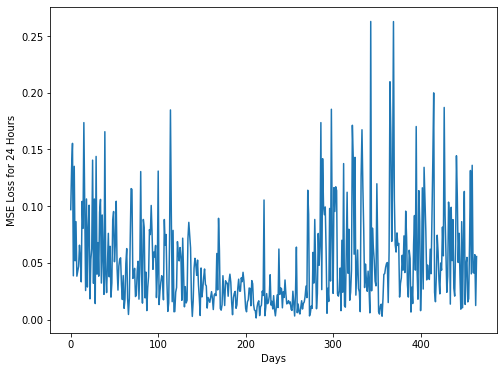

model weights saved successfully


In [33]:
train(model_gru,train_loader, criterion, optimizer_gru,device,'gru_actual')

In [34]:
# Since we want the prediction on 2024-04-22, we need to predict the next four days.
# the actual value of 04-19 and 04-20 hasn't been released as expected. 
# This delay may affect the prediction performance negatively.
gru_pred_1 = my_pred(model_gru,data,N_days, device)
temp_latest_gru = np.append(data, gru_pred_1.squeeze())
gru_pred_2 = my_pred(model_gru, temp_latest_gru, N_days,device)
temp_latest_gru = np.append(temp_latest_gru, gru_pred_2.squeeze())
gru_pred_3 = my_pred(model_gru, temp_latest_gru, N_days,device)
temp_latest_gru = np.append(temp_latest_gru, gru_pred_3.squeeze())
gru_pred_4 = my_pred(model_gru, temp_latest_gru, N_days,device)
# remember to transform back when making final prediction after training!
gru_pred_1 = scaler.inverse_transform(gru_pred_1)
gru_pred_2 = scaler.inverse_transform(gru_pred_2)
gru_pred_3 = scaler.inverse_transform(gru_pred_3)
gru_pred_4 = scaler.inverse_transform(gru_pred_4)
print('Prediction of 04-22 given by GRU is: ')
print(gru_pred_4.squeeze())

Prediction of 04-22 given by GRU is: 
[3208.143  3789.9458 4168.576  4444.357  4519.88   4462.948  4432.443
 4473.364  4542.2427 4612.7817 4679.91   4737.2524 4795.084  4829.494
 4805.749  4845.4766 4891.9614 4912.674  4939.0674 4921.15   4959.16
 4971.9014 4992.4985 5010.1196]


In [35]:
model_lstm = LSTM_Net(N_days,32).to(device)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

lstm_actual, Train Epoch: 1/5, loss: 0.051
lstm_actual, Train Epoch: 2/5, loss: 0.048
lstm_actual, Train Epoch: 3/5, loss: 0.048
lstm_actual, Train Epoch: 4/5, loss: 0.049
lstm_actual, Train Epoch: 5/5, loss: 0.050


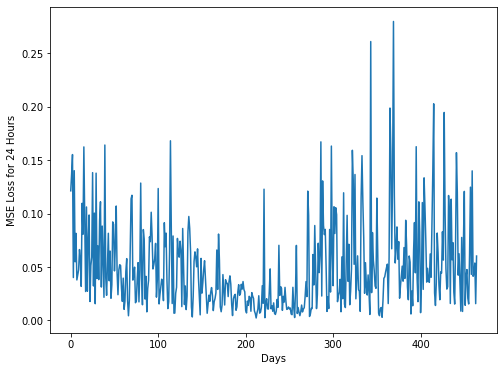

model weights saved successfully


In [36]:
train(model_lstm,train_loader, criterion, optimizer_lstm, device,'lstm_actual')

In [37]:
# Since we want the prediction on 2024-04-22, we need to predict the next four days.
# the actual value of 04-19 and 04-20 hasn't been released as expected. 
# This delay may affect the prediction performance negatively.
lstm_pred_1 = my_pred(model_lstm,data,N_days, device)
temp_latest_lstm = np.append(data, lstm_pred_1.squeeze())
lstm_pred_2 = my_pred(model_lstm, temp_latest_lstm, N_days,device)
temp_latest_lstm = np.append(temp_latest_lstm, lstm_pred_2.squeeze())
lstm_pred_3 = my_pred(model_lstm, temp_latest_lstm, N_days,device)
temp_latest_lstm = np.append(temp_latest_lstm, lstm_pred_3.squeeze())
lstm_pred_4 = my_pred(model_lstm, temp_latest_lstm, N_days,device)
# remember to transform back when making final prediction after training!
lstm_pred_1 = scaler.inverse_transform(lstm_pred_1)
lstm_pred_2 = scaler.inverse_transform(lstm_pred_2)
lstm_pred_3 = scaler.inverse_transform(lstm_pred_3)
lstm_pred_4 = scaler.inverse_transform(lstm_pred_4)
print('Prediction of 04-22 given by LSTM is: ')
print(lstm_pred_4.squeeze())

Prediction of 04-22 given by LSTM is: 
[4633.0767 5011.5776 5171.785  5257.837  5243.933  5078.576  4926.8906
 4848.4106 4863.9263 5004.926  5069.934  5096.8755 5121.5757 5131.8965
 5118.5454 5120.7744 5135.137  5135.8594 5133.509  5129.537  5139.325
 5135.2    5134.868  5137.3047]


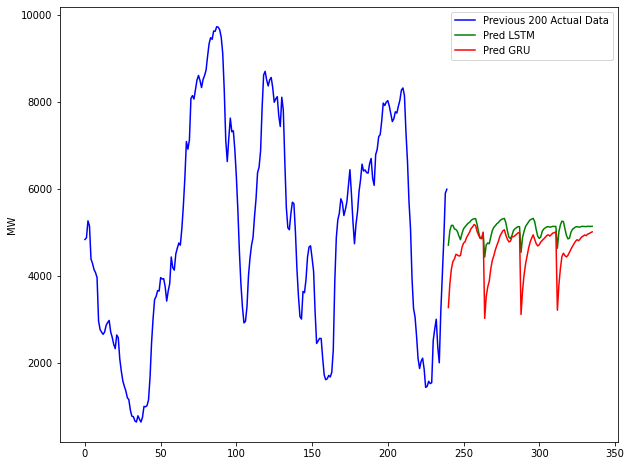

In [38]:
# compare the outputs from the two models
plt.figure(figsize=(10,8))
plt.plot(range(240),scaler.inverse_transform(data[:,np.newaxis])[-240:],label='Previous 200 Actual Data', color='blue')
plt.plot(range(240,336), list(lstm_pred_1)+list(lstm_pred_2)+list(lstm_pred_3)+list(lstm_pred_4),label='Pred LSTM', color='green')
plt.plot(range(240,336), list(gru_pred_1)+list(gru_pred_2)+list(gru_pred_3)+list(gru_pred_4),label='Pred GRU', color='red')
plt.ylabel('MW')
plt.legend()
plt.show()

We find that the prediction from either methods seem plausible. Next we will try to use forecast data to help us. First we need to clean the data in the forecast set, since there are negative values in it. Here we just replace them with their previous value. 

In [39]:
# deal with negative values as mentioned above
df = pd.DataFrame(data_forecast, columns=['Forecast Values'])
df['Forecast Values'] = df['Forecast Values'].apply(lambda x: np.nan if x < 0 else x)
df['Forecast Values'] = df['Forecast Values'].fillna(method='ffill')

data_forecast = df['Forecast Values'].to_list()

In [40]:
# concat actual data till 4/18
data = pd.read_csv('Wind_Actual.csv')['MW'].to_list()
latest_actual = pd.read_csv('latest_actual.csv')['wind_generation_mw'].to_list()[::-1]
data = data + latest_actual

In [41]:
all_data = data + data_forecast
# transform all the data we use within -1,1
scaler = MinMaxScaler()
all_data_scaled = scaler.fit_transform(np.array(all_data).reshape(-1,1)).squeeze()

In [42]:
# split actual and forecast data
actual_data = all_data_scaled[:len(data)]
forecast_data = all_data_scaled[len(data):]

Here we will train a GRU net also using the forecast data. In specific, we will **use previous N_days actual data together with the prediction for the next day** to predict the next 24 hours' MW. The input would be of shape (Batch_size, 24, N_days+1).

In [43]:
# reconstruct the dataset since we now includes forecast data
class MixedDataset(Dataset):
    def __init__(self, actual_data, forecast_data, N_days):
        self.actual_data = actual_data
        self.forecast_data = forecast_data
        self.length = len(self.actual_data) // 24 - N_days
        self.N_days = N_days

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        start_actual = 24 * idx
        end_actual = 24 * (idx + self.N_days)
        sample = self.actual_data[start_actual:end_actual]
        pred = self.forecast_data[end_actual:end_actual+24]
        sample = np.append(sample, pred)
        if len(sample) % 24 != 0:
            raise StopIteration
        sample = sample.astype('float').reshape(24, -1)
        label = self.actual_data[end_actual:end_actual + 24]
        return sample, label
    

In [44]:
N_days = 3 # be careful when loading weights if change this parameter since u changed the model
batch_size = 1
ds = MixedDataset(actual_data, forecast_data, N_days)
train_loader = DataLoader(ds,batch_size)

model_gru_2 = GRU_Net(N_days+1,64,num_layers=2,dropout=0.3).to(device)
load_weights(model_gru_2, 'gru_mixed')
criterion = torch.nn.MSELoss()
optimizer_gru = torch.optim.Adam(model_gru_2.parameters(), lr=0.001)
n_epochs = 5

gru_mixed, Train Epoch: 1/5, loss: 0.042
gru_mixed, Train Epoch: 2/5, loss: 0.041
gru_mixed, Train Epoch: 3/5, loss: 0.041
gru_mixed, Train Epoch: 4/5, loss: 0.041
gru_mixed, Train Epoch: 5/5, loss: 0.041


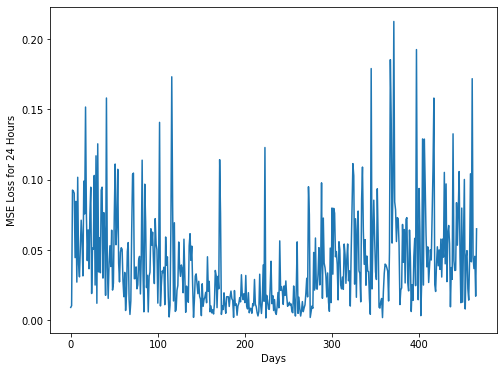

model weights saved successfully


In [45]:
train(model_gru_2, train_loader, criterion, optimizer_gru, device,'gru_mixed')

In [49]:
def my_pred_2(model, actual_data, forecast_data, N_days, device):
    model.eval()
    with torch.no_grad():
        last_sample = actual_data[-N_days*24:]
        last_sample = np.append(last_sample,forecast_data).reshape(24,-1)
        last_sample = torch.from_numpy(last_sample).float().to(device)
        pred = model(last_sample)[0].cpu().numpy()
    return pred

In [50]:
# Since we want the prediction on 2024-04-20, we need to predict the next four days.
gru2_pred_1 = my_pred_2(model_gru_2,actual_data, forecast_data[-24*4:-24*3],N_days, device)
temp_latest_gru2 = np.append(actual_data, gru2_pred_1.squeeze())
gru2_pred_2 = my_pred_2(model_gru_2, temp_latest_gru2,forecast_data[-24*3:-24*2],N_days,device)
temp_latest_gru2 = np.append(temp_latest_gru2, gru2_pred_2.squeeze())
gru2_pred_3 = my_pred_2(model_gru_2, temp_latest_gru2,forecast_data[-24*2:-24*1],N_days,device)
temp_latest_gru2 = np.append(temp_latest_gru2, gru2_pred_3.squeeze())
gru2_pred_4 = my_pred_2(model_gru_2, temp_latest_gru2,forecast_data[-24:],N_days,device)
# remember to transform back
gru2_pred_1 = scaler.inverse_transform(gru2_pred_1)
gru2_pred_2 = scaler.inverse_transform(gru2_pred_2)
gru2_pred_3 = scaler.inverse_transform(gru2_pred_3)
gru2_pred_4 = scaler.inverse_transform(gru2_pred_4)
print('Prediction of 04-20 given by GRU using forecast data is: ')
print(gru2_pred_4.squeeze())

Prediction of 04-20 given by GRU using forecast data is: 
[3552.6155 3781.7231 3913.4326 3993.3354 4061.5483 4120.396  4152.453
 4191.508  4228.383  4269.273  4307.5806 4342.646  4340.7812 4361.7705
 4391.017  4419.008  4441.898  4459.3604 4405.5317 4377.862  4335.897
 4437.1333 4534.097  4604.6846]


In [54]:
df = pd.DataFrame({'Date':'04/22/2024','HE':list(range(1,25)),'Area':'RTO','MW':gru2_pred_4.squeeze()})
df.to_csv('2024-04-22_Pred_Xinqiao_Tong.csv',index=False)

This is the final prediction.

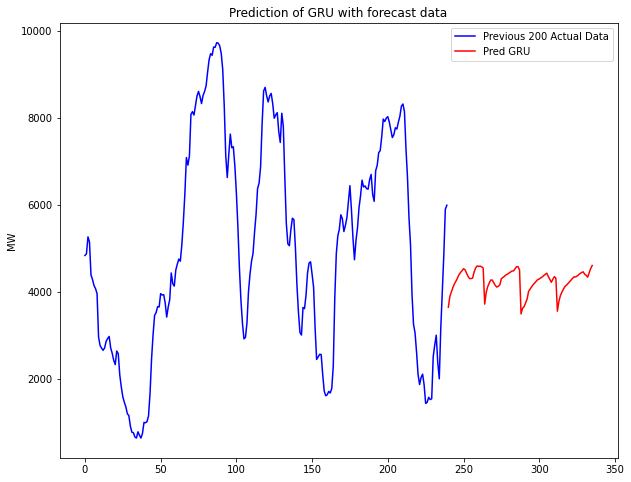

In [52]:
# compare the outputs from the two models
plt.figure(figsize=(10,8))
plt.plot(range(240), scaler.inverse_transform(actual_data[:,np.newaxis])[-240:],label='Previous 200 Actual Data', color='blue')
plt.plot(range(240,336),list(gru2_pred_1)+list(gru2_pred_2)+list(gru2_pred_3)+list(gru2_pred_4) ,label='Pred GRU', color='red')
plt.ylabel('MW')
plt.legend()
plt.title('Prediction of GRU with forecast data')
plt.show()